# Supervised Anomaly Detection with Random Forest

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sqlite3

with sqlite3.connect('../../ch_11/logs/logs.db') as conn:
    logs_2018 = pd.read_sql(
        'SELECT * FROM logs WHERE datetime BETWEEN "2018-01-01" AND "2019-01-01";', 
        conn, parse_dates=['datetime'], index_col='datetime'
    )
    hackers_2018 = pd.read_sql(
        'SELECT * FROM attacks WHERE start BETWEEN "2018-01-01" AND "2019-01-01";', 
        conn, parse_dates=['start', 'end']
    ).assign(
        duration=lambda x: x.end - x.start, 
        start_floor=lambda x: x.start.dt.floor('min'),
        end_ceil=lambda x: x.end.dt.ceil('min')
    )

## Get training and testing sets

In [2]:
def get_X(log, day):
    """
    Get data we can use for the X
    
    Parameters:
        - log: The logs dataframe
        - day: A day or single value we can use as a datetime index slice
    
    Returns: 
        A pandas DataFrame
    """
    return pd.get_dummies(log[day].assign(
        failures=lambda x: 1 - x.success
    ).query('failures > 0').resample('1min').agg(
        {'username':'nunique', 'failures': 'sum'}
    ).dropna().rename(
        columns={'username':'usernames_with_failures'}
    ).assign(
        day_of_week=lambda x: x.index.dayofweek, 
        hour=lambda x: x.index.hour
    ).drop(columns=['failures']), columns=['day_of_week', 'hour'])

def get_y(datetimes, hackers, resolution='1min'):
    """
    Get data we can use for the y (whether or not a hacker attempted a log in during that time).
    
    Parameters:
        - datetimes: The datetimes to check for hackers
        - hackers: The dataframe indicating when the attacks started and stopped
        - resolution: The granularity of the datetime. Default is 1 minute.
        
    Returns:
        A pandas Series of booleans.
    """
    date_ranges = hackers.apply(
        lambda x: pd.date_range(x.start_floor, x.end_ceil, freq=resolution), 
        axis=1
    )
    dates = pd.Series()
    for date_range in date_ranges:
        dates = pd.concat([dates, date_range.to_series()])
    return datetimes.isin(dates)

def get_X_y(log, day, hackers):
    """
    Get the X, y data to build a model with.
    
    Parameters:
        - log: The logs dataframe
        - day: A day or single value we can use as a datetime index slice
        - hackers: The dataframe indicating when the attacks started and stopped
        
    Returns:
        X, y tuple where X is a pandas DataFrame and y is a pandas Series
    """
    X = get_X(log, day)
    y = get_y(X.reset_index().datetime, hackers)
    return X, y

In [3]:
X_train, y_train = get_X_y(logs_2018, '2018-01', hackers_2018)
X_test, y_test = get_X_y(logs_2018, '2018-02', hackers_2018)

## Random Forest
Accepting all the defaults.

In [4]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0, n_estimators=100).fit(X_train, y_train)

In [5]:
preds = rf.predict(X_test)
pd.Series(preds).value_counts()

False    37790
True        13
dtype: int64

## Evaluate the Model

In [6]:
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     37787
        True       0.92      0.75      0.83        16

   micro avg       1.00      1.00      1.00     37803
   macro avg       0.96      0.87      0.91     37803
weighted avg       1.00      1.00      1.00     37803



Text(0.5, 0.98, 'Random Forest Classifier')

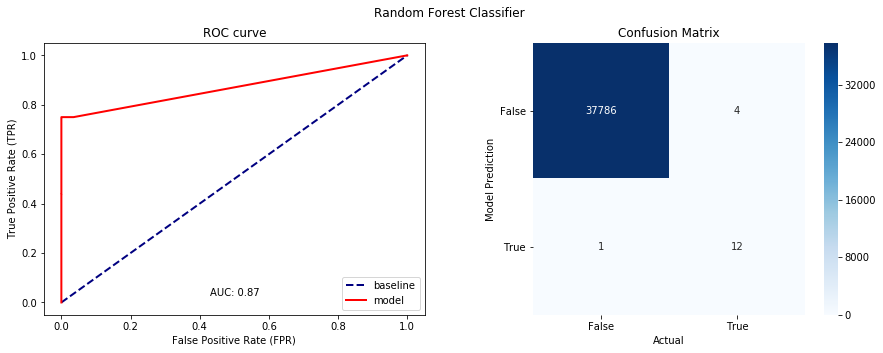

In [7]:
from ml_utils.classification import confusion_matrix_visual, plot_roc

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_roc(y_test, rf.predict_proba(X_test)[:,1], ax=axes[0])
confusion_matrix_visual(y_test, preds, ax=axes[1], class_labels=[False, True])
plt.suptitle('Random Forest Classifier')